In [1]:
import cv2
import pandas as pd
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

SIZE_FACE = 48
EMOTIONS = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
np.random.seed(42)


Using TensorFlow backend.
/home/charles.xavier.verleyen/yes/envs/emotions-recognition/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Read data
data = pd.read_hdf('./data/fer2013.h5','data')

# Images have to be reshaped for Keras (depth dimension = 1 for grayscale and 3 for RGB)
images = np.array(data["images"].tolist()).reshape(data["images"].values.shape[0], SIZE_FACE, SIZE_FACE,1)

# Labels have to be one hot encoded for Keras
labels = np_utils.to_categorical(data["emotion"].values, len(EMOTIONS))


X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.05, random_state=42)

In [3]:
model = Sequential()
model.add(Convolution2D(64, (5, 5), activation='relu', input_shape=[SIZE_FACE, SIZE_FACE, 1]))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(128, (4, 4), activation='relu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(3072, activation='relu'))
model.add(Dense(len(EMOTIONS), activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1)

score = model.evaluate(X_test, Y_test, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 128)         131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
__________

In [4]:
from keras.models import load_model

model.save('./data/keras_model.h5')  # creates a HDF5 file 'keras_model.h5'
del model  # deletes the existing model

# returns a compiled model
model = load_model('./data/keras_model.h5')

score = model.evaluate(X_test, Y_test, verbose=1)

print("Accuracy on test dataset: ", score[1]*100)

699/699 [==============================] - 0s     
Accuracy on test dataset:  63.233190178


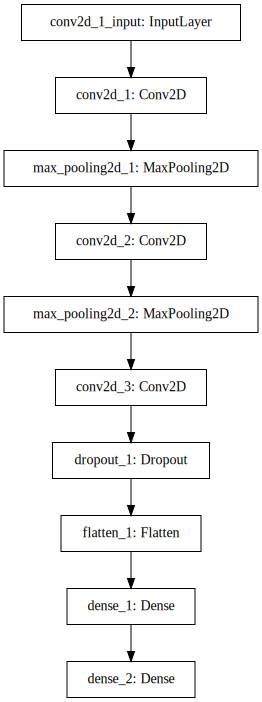

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
from keras.utils import plot_model

# returns a compiled model
model = load_model('./data/keras_model.h5')

plot_model(model, show_shapes=True, to_file='./data/model.png')

SVG(model_to_dot(model).create(prog='dot', format='svg'))

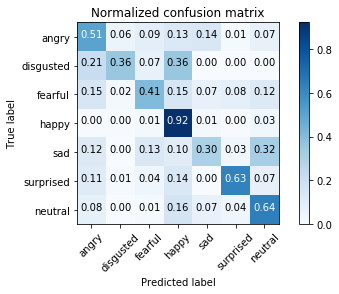

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
y_pred = model.predict(X_test)


cnf_matrix = confusion_matrix(Y_test.argmax(1), y_pred.argmax(1))
np.set_printoptions(precision=2)


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=EMOTIONS, normalize=True,
                      title='Normalized confusion matrix')

plt.show()